In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback, MBartConfig
from transformers import MBartForConditionalGeneration, MBartTokenizerFast,MBartTokenizer,Trainer, TrainingArguments

from transformers import DataCollatorForSeq2Seq
from hftrim.TokenizerTrimmer import TokenizerTrimmer
from hftrim.ModelTrimmers import MBartTrimmer

from transformers import PreTrainedTokenizerFast
# from transformers.convert_slow_tokenizer import convert_slow_tokenizer
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from random import randrange
import evaluate
import nltk
import numpy as np
from collections import Counter
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install peft

In [3]:
# !pip install nltk

In [4]:
# !pip install evaluate

In [5]:
# !pip install rouge_score

In [6]:
# !pip install py7zr

In [7]:
# !pip install transformers --upgrade

## model

In [9]:
model_id="facebook/mbart-large-cc25"
src_lang = "et_EE" # Example source language code
tgt_lang = "et_EE" # Example target language code

In [9]:
tokenizer = MBartTokenizerFast.from_pretrained(model_id)
tokenizer_slow = MBartTokenizer.from_pretrained(model_id)
model = MBartForConditionalGeneration.from_pretrained(model_id)

In [10]:
# Important: Set both source and target languages
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

tokenizer_slow.src_lang = src_lang
tokenizer_slow.tgt_lang = tgt_lang

In [11]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
#share of params in embedding
print(msize(model.model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.41913215486098887
0.41913215486098887


## data

In [3]:
dataset_id = "TalTechNLP/samsum_ee"
dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 14732
Test dataset size: 819


In [4]:
dataset['train']=dataset['train'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)
dataset['test'] = dataset['test'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)

In [5]:
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 13199
Test dataset size: 809


In [6]:
train_dataset = dataset['train'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)
train_dataset

Dataset({
    features: ['id', 'dialogue', 'summary', 'en_dialogue', 'en_summary'],
    num_rows: 13199
})

In [7]:
test_dataset = dataset['test'].filter(lambda example, idx: example['summary'] is not None and example['dialogue'] is not None, with_indices=True)
test_dataset

Dataset({
    features: ['id', 'dialogue', 'summary', 'en_dialogue', 'en_summary'],
    num_rows: 809
})

## trim models vocab

In [17]:
texts4vocab=train_dataset['dialogue']+train_dataset['summary']
len(texts4vocab)

26398

In [18]:
config = MBartConfig.from_pretrained(model_id)

In [ ]:
# trim tokenizer
tokenizer_slow_trim = TokenizerTrimmer(tokenizer_slow)
tokenizer_slow_trim.make_vocab(texts4vocab)
tokenizer_slow_trim.make_tokenizer()

# trim model
model_trim = MBartTrimmer(model, config, tokenizer_slow_trim.trimmed_tokenizer)
model_trim.make_weights(tokenizer_slow_trim.trimmed_vocab_ids)
model_trim.make_model()

Token indices sequence length is longer than the specified maximum sequence length for this model (1981 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 250000/250000 [00:00<00:00, 1167225.66it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Save trimmed model and tokenizer

In [ ]:
tokenizer_slow_trim.trimmed_tokenizer.save_pretrained('mbart-large-cc25_et')
model_trim.trimmed_model.save_pretrained('mbart-large-cc25_et')

## Load model and tokenizer

In [10]:
# tokenizer = MBartTokenizer.from_pretrained('mbart-large-cc25_et')
tokenizer = MBartTokenizerFast.from_pretrained("mbart-large-cc25_et/", from_slow=True)
tokenizer.src_lang = src_lang
tokenizer.tgt_lang = tgt_lang

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
model = MBartForConditionalGeneration.from_pretrained('mbart-large-cc25_et', max_length=1024)

## prep data for training

In [ ]:
max_source_length = 1024

In [ ]:
max_target_length=512

In [ ]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["dialogue"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["summary"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])

In [ ]:
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["dialogue", "summary", "id"])

## evaluator

In [12]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [ ]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [ ]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [ ]:
# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=True,
    learning_rate=5e-5,
    num_train_epochs=10,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

In [ ]:
trainer.train()

## calculate metrics

In [13]:
model_id="mbart-large-cc25-TalTechNLP/samsum_ee/checkpoint-6600/"
tokenizer = MBartTokenizerFast.from_pretrained("mbart-large-cc25_et/",from_slow=True)
model = MBartForConditionalGeneration.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
model=model.to('cuda')

In [15]:
def calc_texts_labels_metrics(texts, summaries, model, tokenizer, max_input_length=1024, max_output_length=512, batch_size = 10):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to('cuda')
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [16]:
eval_metrics=calc_texts_labels_metrics(test_dataset['dialogue'], test_dataset['summary'], model, tokenizer)
eval_metrics

/tmp/ipykernel_1908/2617402847.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  outputs = torch.tensor(padded_predictions)


{'rouge1': 37.9071,
 'rouge2': 16.2802,
 'rougeL': 31.5887,
 'rougeLsum': 35.1778,
 'gen_len': 241.59950556242273}

## example usage

In [17]:
def summarize(text, model, tokenizer, max_input_length=1024, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [18]:
summarize(dataset['test'][0]['dialogue'], model, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Amanda ei leia Betty telefoninumbrit. Betty helistas Larryle viimati, kui nad koos pargis olid.


In [19]:
dataset['test'][0]['dialogue']

'Hannah: Hei, kas sul on Betty number?\nAmanda: Vaatan järele.\nHannah: <file_gif>\nAmanda: Vabandust, ei leia seda.\nAmanda: Küsi Larrylt.\nAmanda: Ta helistas talle viimati, kui me koos pargis olime.\nHannah: Ma ei tunne teda hästi.\nHannah: <file_gif>\nAmanda: Ära ole häbelik, ta on väga tore.\nHannah: Kui sa ütled nii..\nHannah: Ma eelistaksin, et sa talle sõnumi saadaksid.\nAmanda: Lihtsalt saada talle sõnum 🙂\nHannah: Urgh.. Olgu siis\nHannah: Nägemist\nAmanda: Nägemist-nägemist'

In [20]:
dataset['test'][0]['summary']

'Hannah vajab Betty telefoninumbrit, kuid Amandal seda pole. Ta peab Larryga ühendust võtma.'

In [21]:
summarize(dataset['test'][1]['dialogue'], model, tokenizer)

Eric ja Rob vaatavad Masini etendust, mis näitab, kuidas ameeriklased näevad venelasi.


In [22]:
dataset['test'][1]['dialogue']

"Eric: MASIN!\nRob: See on nii lahe!\nEric: Ma tean! Ja näitab, kuidas ameeriklased näevad venelasi ;)\nRob: Ja see on tõesti naljakas!\nEric: Ma tean! Mulle meeldib eriti rongi osa!\nRob: Hahaha! Keegi ei räägi masinaga nii!\nEric: Kas see on tema ainus etendus?\nRob: Ei tea. Ma vaatan järele.\nEric: Kindlasti.\nRob: Selgub, et ei! Mõned tema etendused on Youtube'is.\nEric: Lahe! Ma vaatan neid kohe!\nRob: Mina ka!\nEric: MASIN!\nRob: MASIN!\nEric: Kuni kohtumiseni?\nRob: Muidugi :)"

In [23]:
dataset['test'][1]['summary']

"Eric ja Rob lähevad vaatama stand-up'i YouTube'is."

In [24]:
summarize(dataset['test'][2]['dialogue'], model, tokenizer)

Bob soovib, et Lenny ostaks talle musta paari. Lenny ostab esimese paari või kolmanda paari.


In [25]:
dataset['test'][2]['dialogue']

'Lenny: Kallis, kas sa saaksid mulle millegagi abi anda?\nBob: Muidugi, mis toimub?\nLenny: Millise ma peaksin valima?\nBob: Saada mulle pilte.\nLenny: <file_photo>\nLenny: <file_photo>\nLenny: <file_photo>\nBob: Mulle meeldivad kõige rohkem esimesed.\nLenny: Aga mul on juba lillad püksid. Kas on mõtet omada kahte paari?\nBob: Mul on neli musta paari :D :D\nLenny: Jah, aga kas ma ei peaks valima erinevat värvi?\nBob: Oluline on see, milline annab sulle kõige rohkem riietumisvõimalusi.\nLenny: Nii et ma arvan, et ostan esimese või kolmanda paari siis.\nBob: Vali parim kvaliteet siis.\nLenny: Sul on õigus, aitäh.\nBob: Pole probleemi :)'

In [26]:
dataset['test'][2]['summary']

'Lenny ei suuda otsustada, millised püksid osta. Bob nõustas Lennyt selles küsimuses. Lenny läheb Bobi nõu järgi ja valib kvaliteetseimad püksid.'

In [27]:
summarize(dataset['test'][3]['dialogue'], model, tokenizer)

Emma valmistab täna õhtuks toitu. Ta jõuab koju varsti.


In [28]:
dataset['test'][3]['dialogue']

'Will: hei kallis, mida sa täna õhtuks süüa tahad?\nEmma: oh, ära täna üldse muretse selle pärast\nWill: mida sa selle all mõtled? kas kõik on korras?\nEmma: mitte päris, aga see on ok, ära muretse toiduvalmistamise pärast, mul pole isu\nWill: millal sa koju jõuad?\nEmma: varsti, loodetavasti\nWill: kas sa oled kindel? võib-olla tahad, et ma sind järele tuleksin?\nEmma: ei ei, see on korras. Ma jõuan varsti koju, ma ütlen sulle, kui ma koju jõuan.\nWill: Selge, armastan sind.\nEmma: armastan sind ka.'

In [29]:
dataset['test'][3]['summary']

'Emma tuleb varsti koju ja ta annab Willile teada.'

In [30]:
summarize(dataset['test'][4]['dialogue'], model, tokenizer)

Jane on just tagasi Varssavis. Ollie ei ole vaba õhtusöögiks 19. kuupäeval, kuid 18. kuupäeval on tal pidu. Ollie ja Jane kohtuvad reedel kell 18.00 pärast Ollie kursusi.


In [31]:
dataset['test'][4]['dialogue']

'Ollie: Tere, kas sa oled Varssavis?\nJane: Jah, just tagasi! Muide, kas sa oled vaba õhtusöögiks 19. kuupäeval?\nOllie: Ei ole!\nJane: Aga 18.?\nOllie: Ei, meil on see pidu ja sa pead seal olema, mäletad?\nJane: Oh õige! Ma kaotasin oma kalendri.. aitäh, et meelde tuletasid.\nOllie: Kas me lõunatame sel nädalal?\nJane: Hea meelega!\nOllie: Reede?\nJane: Ok.\nJane: Mida sa mõtled "meil pole enam viskit!" lol..\nOllie: Mida!!!?\nJane: Sa helistasid mulle ja ainus asi, mida ma kuulsin, oli see lause viski kohta... mis sinuga lahti on?\nOllie: Oh oh... väga imelik! Pean olema ettevaatlik, võib-olla on minu telefonis mõni spioon! lol\nJane: Ära muretse, me kontrollime reedel.\nOllie: Ära unusta päikest kaasa võtta.\nJane: Ma ei jõua ära oodata, et Marokosse jõuda..\nOllie: Naudi ja näeme reedel.\nJane: Vabandust, Ollie, mul on väga kiire, mul ei ole homme lõunaks aega, aga ehk kell 18 pärast minu kursusi? See Maroko reis oli nii tore, aga aeganõudev!\nOllie: Ok, teeks siis teed!\nJane: Ole

In [32]:
dataset['test'][4]['summary']

"Jane on Varssavis. Ollie ja Jane korraldavad peo. Jane kaotas oma kalendri. Nad saavad sel nädalal reedel lõunat. Ollie helistas kogemata Jane'ile ja rääkis viskist. Jane tühistab lõunasöögi. Nad kohtuvad kell 18 teeks."

In [33]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(input_text, model, tokenizer)

ja SDP on Soome kõige populaarsem partei Koonderakond. Märtsis langes peaministripartei toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti. SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1, erakonna toetus 1, erakonna toetus 21,7 protsenti ja Koonderakonna toetus 17,4 protsenti. Riikka Purra kodupartei toetus 17,4 protsenti.


## speed Taltech vs fine-tuned tokenizer

In [47]:
def summarize(input_text, model, tokenizer, device='cuda'):
    input_ids = tokenizer(
        input_text, return_tensors="pt"
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to(device))
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [34]:
model_id_taltect="TalTechNLP/mBART-ERRnews"
src_lang = "et_EE" # Example source language code
tgt_lang = "et_EE" # Example target language code

In [35]:
tokenizer_taltech = AutoTokenizer.from_pretrained(model_id_taltect)
model_taltech = AutoModelForSeq2SeqLM.from_pretrained(model_id_taltect)
model_taltech=model_taltech.to('cuda')

In [36]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""

#number of tokens
input_ids = tokenizer(
     input_text*5, return_tensors="pt"
).input_ids
len(input_ids[0])

621

In [37]:
%time _= summarize(input_text, model_taltech, tokenizer_taltech)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Soome kõige populaarsem erakond oli veebruaris Koonderakond, kuid kaotas märtsis sellele tiitli.
CPU times: user 283 ms, sys: 294 µs, total: 284 ms
Wall time: 283 ms


In [38]:
_

In [39]:
%time _=summarize(input_text, model, tokenizer)

ja SDP on Soome kõige populaarsem partei Koonderakond. Märtsis langes peaministripartei toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti. SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1, erakonna toetus 1, erakonna toetus 21,7 protsenti ja Koonderakonna toetus 17,4 protsenti. Riikka Purra kodupartei toetus 17,4 protsenti.
CPU times: user 798 ms, sys: 168 µs, total: 798 ms
Wall time: 797 ms


In [40]:
_

## speed on CPU

In [43]:
msize(model)

373833728

In [44]:
msize(model_taltech)

610851840

In [45]:
torch.set_num_threads(1)

In [48]:
model_taltech=model_taltech.to('cpu')
%time _= summarize(input_text, model_taltech, tokenizer_taltech, device='cpu')

CPU times: user 11.5 s, sys: 18.4 ms, total: 11.5 s
Wall time: 11.5 s


In [49]:
model=model.to('cpu')
%time _= summarize(input_text, model, tokenizer, device='cpu')

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


## visualize training stats

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
log_path = 'mbart-large-cc25-TalTechNLP/samsum_ee/logs/events.out.tfevents.1713096728.2ca00bef5a11.161528.0'

2024-04-18 16:23:22.705603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-18 16:23:22.705624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_tensorboard_data(event_file_path):
    # Initialize an EventAccumulator with size_guidance for auto loading of all data
    ea = event_accumulator.EventAccumulator(event_file_path,
        size_guidance={
            event_accumulator.SCALARS: 0,
            event_accumulator.IMAGES: 0,
            event_accumulator.AUDIO: 0,
            event_accumulator.HISTOGRAMS: 0,
            event_accumulator.TENSORS: 0,
        })

    # Load the data
    ea.Reload()

    # Data extraction examples
    data = {}

    # Extract scalars to a DataFrame
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = pd.DataFrame([(e.step, e.value) for e in events], columns=['Step', tag])

    # Extend this part to handle histograms, images, etc., as needed

    return data

data = load_tensorboard_data(log_path)
# Example to print the available scalar tags and their first few values
for tag, df in data.items():
    print(f"Data for tag: {tag}")
    # print(df.head())
    
df

Data for tag: train/loss
Data for tag: train/learning_rate
Data for tag: train/epoch
Data for tag: eval/loss
Data for tag: eval/rouge1
Data for tag: eval/rouge2
Data for tag: eval/rougeL
Data for tag: eval/rougeLsum
Data for tag: eval/gen_len
Data for tag: eval/runtime
Data for tag: eval/samples_per_second
Data for tag: eval/steps_per_second
Data for tag: train/train_runtime
Data for tag: train/train_samples_per_second
Data for tag: train/train_steps_per_second
Data for tag: train/total_flos
Data for tag: train/train_loss


,Step,train/train_loss
0,16500,1.380043


<AxesSubplot:>

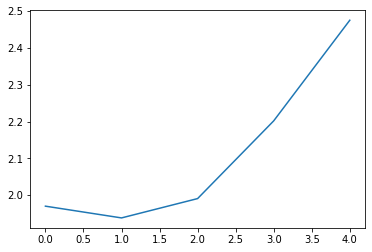

In [3]:
data['eval/loss']['eval/loss'].plot()

<AxesSubplot:>

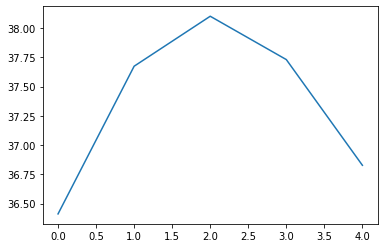

In [5]:
data['eval/rouge1']['eval/rouge1'].plot()

In [7]:
data['eval/rouge1']['eval/rouge1'].max()

38.100799560546875

<AxesSubplot:>

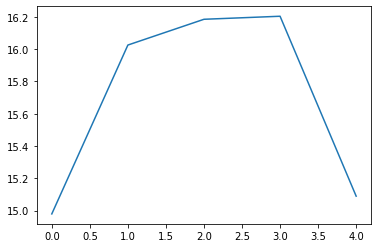

In [6]:
data['eval/rouge2']['eval/rouge2'].plot()